# Chapter 1: Greenhouses Gases - The prime suspect

### Generation of plots based on [the relevant Climate Indicators' report](https://climate.copernicus.eu/climate-indicators/greenhouse-gas-concentrations).

The ongoing climate change and the subsequent incease of earth's temperature is  a hot topic in the recent years; a topic that has lately expanded from the purely scientific communities and touches now almost all aspects of our lives. There is much said about the role that the GreenHouse Gases (GHG) play in this climatic crisis. Let's follow this tutorial and find out if and how the concentrations of two key GHG (carbon dioxide - CO2, and methane - CH4) changed in the last decades.

In this tutorial we will:
1. Search, download, and view data freely available in [Climate Data Store](https://cds.climate.copernicus.eu/cdsapp#!/home) and [Atmosphere Data Store](https://ads.atmosphere.copernicus.eu/cdsapp#!/home).
2. Calculate global and regional monthly timeseries.
3. View time series and analyse trends.
4. Create gridded plots and analyse spatial variations.

### Section 1. Installing & importing the necessary packages.

The first step for being able to analyse and plot the data is to download and import the necessary libraries for this tutorial. In the GitHub repository you can find the full environment that has all the libraries needed for this and the other tutorials. The environment can be installed in Linux with the simple command: `conda env create -f environment.yml`. This would be the best option if you use this and the rest tutorials on your local computer. If you are using this tutorial in Google Colab most of the required libraries are already preinstalled in the environment and the only libraby that should be downloaded is the CSD API.

In [1]:
%pip install cdsapi # this is only needed if the cdsapi library is not already in the environment (e.g. if you run this tutorial in Google Colab)

Note: you may need to restart the kernel to use updated packages.


Let's now import all the required libraries in our environment. We categorized the libraries based on that they are used for: general libraries, libraries for data analysis, and plotting libraries.

In [1]:
# General libraries
from string import ascii_lowercase as ABC # String operations
import datetime # date
import calendar # date calculations
import zipfile # for unzipping data
import os # operating system interfaces library
import cdsapi # CDS API
import urllib3 # Disable warnings for data download via API
urllib3.disable_warnings()

# Libraries for working with multidimensional arrays
import numpy as np # for n-d arrays
import pandas as pd # for 2-d arrays (including metadata for the rows & columns)
import xarray as xr # for n-d arrays (including metadata for all the dimensions)

# Libraries for plotting and visualising data
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.gridspec import GridSpec
import seaborn as sns
import matplotx
import cartopy.crs as ccrs
import cartopy.feature as cfeature
plt.style.use('copernicus.mplstyle') # use the predefined matplotlib style for consistent plotting across all tutorials

### Section 2. Downloading data from CDS.

Let's create a folder were all the data will be stored.

In [2]:
dir_loc = 'data/' # assign folder for storing the downloaded data
os.makedirs(dir_loc, exist_ok=True) # create the folder if not available

Enter CDS API key


We will request data from the Climate Data Store (CDS) programmatically with the help of the CDS API. Let us make use of the option to manually set the CDS API credentials. First, you have to define two variables: `URL` and `KEY` which build together your CDS API key. The string of characters that make up your KEY include your personal User ID and CDS API key. To obtain these, first register or login to the CDS (http://cds.climate.copernicus.eu), then visit https://cds.climate.copernicus.eu/api-how-to and copy the string of characters listed after "key:". Replace the `#########` below with that string.

In [3]:
# CDS key
cds_url = 'https://cds.climate.copernicus.eu/api/v2'
cds_key = 'YOUR_KEY' # please add your key here the format should be as {uid}:{api-key}

Get GHG data from the satellite products, that are available at CDS.
In CDS a user can browse all available data from the search option, and once the selected dataset is identified, one can see from the download tab the exact API request. For example in [this link](https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-methane?tab=form) you can see the satellite methane data. For this tutorial we used the options:
- Processing level: Level 3
- Variable: Column-averaged dry-air mixing ratios of methane (XCH4) and related variables
- Version: 4.4
- Format: zip

In [7]:
c = cdsapi.Client(url=cds_url, key=cds_key)

c.retrieve(
    'satellite-methane',
    {
        'format': 'zip',
        'processing_level': 'level_3',
        'sensor_and_algorithm': 'merged_obs4mips',
        'version': '4.4',
        'variable': 'xch4',
    },
    f'{dir_loc}satellites_CH4.zip')

c.retrieve(
    'satellite-carbon-dioxide',
    {
        'format': 'zip',
        'processing_level': 'level_3',
        'sensor_and_algorithm': 'merged_obs4mips',
        'version': '4.4',
        'variable': 'xco2',
    },
    f'{dir_loc}satellites_CO2.zip')

2023-06-07 10:02:32,242 INFO Welcome to the CDS
2023-06-07 10:02:32,243 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/satellite-methane
2023-06-07 10:02:32,463 INFO Request is completed
2023-06-07 10:02:32,464 INFO Downloading https://download-0021.copernicus-climate.eu/cache-compute-0021/cache/data4/dataset-satellite-methane-2bbfecdd-26ac-415e-b60f-229a76e834dd.zip to data/satellites_CH4.zip (15.1M)
2023-06-07 10:02:41,466 INFO Download rate 1.7M/s   
2023-06-07 10:02:41,688 INFO Welcome to the CDS
2023-06-07 10:02:41,688 INFO Sending request to https://cds.climate.copernicus.eu/api/v2/resources/satellite-carbon-dioxide
2023-06-07 10:02:41,913 INFO Downloading https://download-0020.copernicus-climate.eu/cache-compute-0020/cache/data3/dataset-satellite-carbon-dioxide-2612be20-7d5e-4a83-8fa1-f8739dd06ce1.zip to data/satellites_C02.zip (12.2M)
2023-06-07 10:02:49,255 INFO Download rate 1.7M/s   


Result(content_length=12831918,content_type=application/zip,location=https://download-0020.copernicus-climate.eu/cache-compute-0020/cache/data3/dataset-satellite-carbon-dioxide-2612be20-7d5e-4a83-8fa1-f8739dd06ce1.zip)

The data are downloaded in zip format. Let's unzip them and rename them with an intuitive name.

In [3]:
# unzip the satellite data, rename the file and delete the original zip
for i_ghg in ['CO2', 'CH4']: # loop through both variables
    with zipfile.ZipFile(f'{dir_loc}satellites_{i_ghg}.zip','r') as zip_ref:
        zip_ref.extractall(dir_loc) # unzip file
        source_file = '200301_202112-C3S-L3_GHG-GHG_PRODUCTS-MERGED-MERGED-OBS4MIPS-MERGED-v4.4.nc' # the name of the unzipped file
        os.rename(f'{dir_loc}{source_file}', f'{dir_loc}satellites_{i_ghg}.nc') # rename to more intuitive name
        os.remove(f'{dir_loc}satellites_{i_ghg}.zip') # delete original zip file

# read the data with xarray
co2_satellites = xr.open_dataset(f'{dir_loc}satellites_CO2.nc')
ch4_satellites = xr.open_dataset(f'{dir_loc}satellites_CH4.nc')

Let's observe how the satellite data looks like. Notice that the grid is 5 degrees lot, lat, and that the time coordinate refers to the middle day of the relevant month. There are also a lot of different variable, including the CO2 values and standard deviations related to the uncertainty.

In [4]:
co2_satellites

<xarray.Dataset>
Dimensions:                  (time: 228, bnds: 2, lat: 36, lon: 72, pressure: 10)
Coordinates:
  * time                     (time) datetime64[ns] 2003-01-16T12:00:00 ... 20...
  * lat                      (lat) float64 -87.5 -82.5 -77.5 ... 77.5 82.5 87.5
  * lon                      (lon) float64 -177.5 -172.5 -167.5 ... 172.5 177.5
Dimensions without coordinates: bnds, pressure
Data variables:
    time_bnds                (time, bnds) datetime64[ns] ...
    lat_bnds                 (lat, bnds) float64 ...
    lon_bnds                 (lon, bnds) float64 ...
    pre                      (pressure) float64 ...
    pre_bnds                 (pressure, bnds) float64 ...
    land_fraction            (lat, lon) float64 ...
    xco2                     (time, lat, lon) float32 ...
    xco2_nobs                (time, lat, lon) float64 ...
    xco2_stderr              (time, lat, lon) float32 ...
    xco2_stddev              (time, lat, lon) float32 ...
    column_averaging_kernel  (time, pressure, lat, lon) float32 ...
    vmr_profile_co2_apriori  (time, pressure, lat, lon) float32 ...
Attributes: (12/28)
    activity_id:            obs4MIPs
    comment:                Since long time, climate modellers use ensemble a...
    contact:                Maximilian Reuter (maximilian.reuter@iup.physik.u...
    Conventions:            CF-1.7 ODS-2.1
    creation_date:          2022-07-10T09:25:22Z
    data_specs_version:     2.1.0
    ...                     ...
    source_version_number:  v4.4
    title:                  C3S XCO2 v4.4
    tracking_id:            ca42b88b-c774-4a16-9ad8-a49f9a4839fd
    variable_id:            xco2
    variant_info:           Best Estimate
    variant_label:          BE

The selected datasets have data up to 2021. For the ones interested in expanding the data with near-real time information, satellite measurements for the recent period are available [here](http://www.iup.uni-bremen.de/~ghguser/gosat_focal.php).

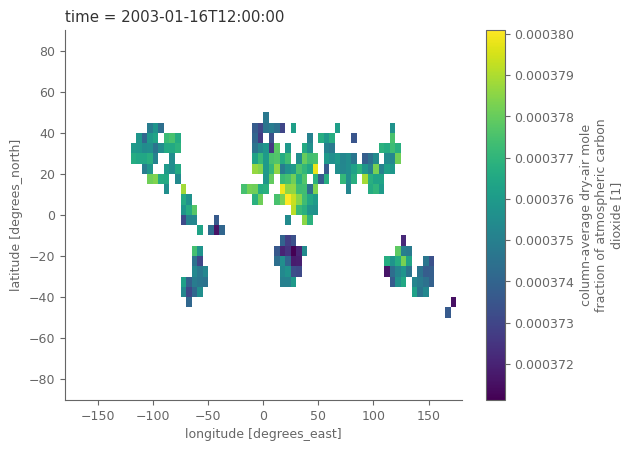

In [5]:
# "quick and dirty" plot of the data
co2_satellites['xco2'].isel(time=0).plot() 

In [7]:
# change temporal coordinates to refer to the start of the month and keep only the variables of interest
co2_satellites = co2_satellites[['xco2', 'xco2_stddev', 'xco2_stderr', 'land_fraction']] # keep only the variables of interest
co2_satellites = co2_satellites.assign_coords( {'time': pd.to_datetime(co2_satellites.time.dt.strftime('%Y%m01'))} ) # date at start of month

ch4_satellites = ch4_satellites[['xch4', 'xch4_stddev', 'xch4_stderr', 'land_fraction']] # keep only the variables of interest
ch4_satellites = ch4_satellites.assign_coords( {'time': pd.to_datetime(ch4_satellites.time.dt.strftime('%Y%m01'))} ) # date at start of month


### Section 3. Calculating and plotting the quantities of interest.

#### Global average monthly values over land for 60N-60S latitudes. 

We will calculate the global average monthly values, as well as a 12-month temporally-smoothed global average, for removing possible seasonal effects. For the temporal smoothing, let's be very precise and take into consideration that each month has different number of days.

Because we have 2 different datasets, let's make a small function that calculates the global average for each dataset. But before doing so, here we demonstrate the steps one by one, for the CO2 dataset.

Let's start by croping the dataset to the region of interest and masking the data to use only values over land, as satellite measurements are not reliable over oceans.

In [12]:
used_latitudes = slice(-60, 60) # note that the latitude coordinates should respect the order of the dataset (in our case it's ascending)
co2_cropped = co2_satellites.sel(lat=used_latitudes)
co2_cropped = co2_cropped.where(co2_cropped['land_fraction']>.5) # anything with land_fraction over 50% is considered as land

Now we can define the auxiliary data needed for the temporal smoothing.

In [8]:
smoothed_n_months = 12 # months used for the temporal smoothing

# get number of days for each month
days_month = [calendar.monthrange(yr, mn)[1] for yr, mn in zip(co2_cropped.time.dt.year.values, co2_cropped.time.dt.month.values)]

# temporal weights as xarray object (helps with automated alignment of the data for the calculations at the next steps)
weights_temporal = co2_cropped.time.astype(int)*0+days_month 

# weights should be changed to NaN for the cells that hava NaN in the measurement
weights_temporal = weights_temporal.where(~np.isnan(co2_cropped))

It's time to calculate the temporally smoothed data for each grid cell.

In [9]:
# rolling sum of the product of satellite measurements with the days per month
temp_smoothed = (co2_cropped*weights_temporal).rolling(time=smoothed_n_months, min_periods=1, center=True).sum()
# min_periods=1 is needed, so that even if there is only 1 non-NaN value, there will be a result and not NaN

# divide with total number of days for getting the final weighted temporally-smoothed timeseries
temp_smoothed = temp_smoothed/weights_temporal.rolling(time=smoothed_n_months, min_periods=1, center=True).sum()

Moving on with the spatial averaging now.

The data are projected in lat/lon system. This system does not have equal areas for all grid cells, but as we move closer to the poles, the area of the cells is reducing. These differences can be accounted when weighting the cells with the cosine of their latitude.

In [13]:
wgts = np.cos(np.deg2rad(co2_cropped.lat)).clip(0, 1) # weights for CO2 satellite data
wgts # the clip function above is for reassuring that all values will be between 0-1 regardless of the  of machine's precision

<xarray.DataArray 'lat' (lat: 24)>
array([0.53729961, 0.60876143, 0.67559021, 0.73727734, 0.79335334,
       0.84339145, 0.88701083, 0.92387953, 0.95371695, 0.97629601,
       0.99144486, 0.99904822, 0.99904822, 0.99144486, 0.97629601,
       0.95371695, 0.92387953, 0.88701083, 0.84339145, 0.79335334,
       0.73727734, 0.67559021, 0.60876143, 0.53729961])
Coordinates:
  * lat      (lat) float64 -57.5 -52.5 -47.5 -42.5 -37.5 ... 42.5 47.5 52.5 57.5
Attributes:
    standard_name:  latitude
    long_name:      latitude
    units:          degrees_north
    axis:           Y
    comment:        latitude center

Let's now combine both data (actual and temporally smoothed) in one dataset.

In [11]:
spatial_aver = co2_cropped.weighted(wgts).mean(['lat', 'lon']) # average of satellite data
spatial_aver = spatial_aver.assign_coords({'type': 'monthly'}).expand_dims('type') # create new coordinate
spatial_aver_temp_smoothed = temp_smoothed.weighted(wgts).mean(['lat', 'lon']) # temporal smoothing
spatial_aver_temp_smoothed = spatial_aver_temp_smoothed.assign_coords({'type': f'{smoothed_n_months}-month smoothed'}).expand_dims('type')

spatial_aver = xr.concat([spatial_aver, spatial_aver_temp_smoothed], dim='type') # combine the monthly and smoothed data in 1 dataset
spatial_aver

<xarray.Dataset>
Dimensions:        (time: 228, type: 2)
Coordinates:
  * time           (time) datetime64[ns] 2003-01-01 2003-02-01 ... 2021-12-01
  * type           (type) <U17 'monthly' '12-month smoothed'
Data variables:
    xco2           (type, time) float64 0.0003758 0.0003765 ... 0.000414
    xco2_stddev    (type, time) float64 1.614e-06 1.396e-06 ... 1.635e-06
    xco2_stderr    (type, time) float64 6.665e-07 7.217e-07 ... 1.161e-06
    land_fraction  (type, time) float64 0.9322 0.9322 0.9322 ... 0.9322 0.9322

Maybe you noticed that we first did the temporal smoothing for each grid cell, and then performed the global average. This requires more computations from doing first the global average and then the temporal smoothing on the derived single global timeseries. The former though is the correct one, and although the results are very similar (`a to do task for the ones interested`), the differences can considerably increase for datasets that have missing values at different grid cells each time step, as in our case with the satellite data.

Now that we showed how the data are calculated for each step, let's create a function for making our lifes a bit easier.

In [20]:
def spatial_average_function(input_dataset, lat_subset, temp_smoothing):

    '''
    Calculate the spatial average of a gridded xarray dataset/dataarray for user-selected subdomain of latitudes
    
    input_dataset: xarray dataset or dataarray
    lat_subset: slice object
    temp_smoothing: number of months used for temporal smoothing (integer)
    '''
    dataset_subset = input_dataset.sel(lat=lat_subset) # subset the latitudes (do it first for having less data for proceccing later on)

    # get the weights for the temporal smoothing based on number of days per month
    days_month = [calendar.monthrange(yr, mn)[1] for yr, mn in zip(dataset_subset.time.dt.year.values, dataset_subset.time.dt.month.values)]
    weights_temporal = dataset_subset.time.astype(int)*0+days_month # temporal weights as xarray object (helps for automatic arrangements later)
    # weights should be changed to NaN for the cells that hava NaN in the measurement
    weights_temporal = weights_temporal.where(~np.isnan(dataset_subset))
    
    # created temporally-smoothed timeseries
    temp_smoothed = (dataset_subset*weights_temporal).rolling(time=temp_smoothing, min_periods=1, center=True).sum()
    temp_smoothed /= weights_temporal.rolling(time=temp_smoothing, min_periods=1, center=True).sum()

    # get weights for the spatial average
    wghts = np.cos(np.deg2rad(dataset_subset.lat)).clip(0, 1)
    
    # get spatially-weighted mean
    spatial_av = dataset_subset.weighted(wghts).mean(['lat', 'lon'])
    spatial_av = spatial_av.assign_coords({'type': 'monthly'}).expand_dims('type')

    # get temporally-smoothed spatial average
    spatial_aver_temp_smoothed = temp_smoothed.weighted(wghts).mean(['lat', 'lon']) # temporal smoothing
    spatial_aver_temp_smoothed = spatial_aver_temp_smoothed.assign_coords({'type': f'{temp_smoothing}-month smoothed'}).expand_dims('type')

    spatial_av = xr.concat([spatial_av, spatial_aver_temp_smoothed], dim='type') # combine the monthly and smoothed data in 1 dataset

    return spatial_av

#### Calculating the annual mean growth rates (to do...)

In [85]:
difs = co2_satellites.groupby('time.month').apply(lambda x: x.diff('time')).sortby('time')
difs = spatial_average_function(difs, slice(-60, 60), 12)
difs = difs.assign_coords({'time': pd.to_datetime(difs.time.values)-np.timedelta64(1, 'Y')})

<Axes: xlabel='year'>

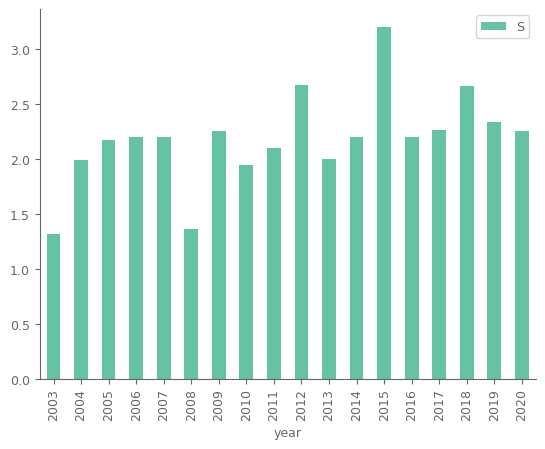

In [98]:
(difs['xco2']*10**6).groupby('time.year').mean().sel(type='monthly').to_dataframe('S').plot.bar()

#### Plot the timeseries of the global average monthly concentrations of the GHG. 

In [21]:
co2_land_data = co2_satellites['xco2'].where(co2_satellites['land_fraction']>.5) # keep only data over land
co2_spatial_average = spatial_average_function(co2_land_data, slice(-60, 60), 12)*10**6 # spatial average and convert to ppm (* 10**6)
ch4_land_data = ch4_satellites['xch4'].where(ch4_satellites['land_fraction']>.5) # keep only data over land
ch4_spatial_average = spatial_average_function(ch4_land_data, slice(-60, 60), 12)*10**9 # spatial average and convert to ppb (* 10**9)

Create plotting functions for the timeseries and the barplot.

In [22]:
def timeseries_plot(dataset_used, dimension_used, ax_used):

    'Create function for plotting timeseries (as lines)'
    
    # pre-processing 
    dataset_used = dataset_used.rename({dimension_used: 'dim_used'}) # rename the dimension for the plotting subset
    
    # plot line timeseries
    yy_all = [dataset_used.sel(dim_used=i_dim_used).values for i_dim_used in dataset_used.dim_used.values]
    for yy, label in zip(yy_all, dataset_used.dim_used.values):
        ax_used.plot(dataset_used.time.values, yy, label=label) 

    matplotx.line_labels(ax=ax_used) # add legend as colored text next to the right end of the relevant line

    # format the axes
    ax_used.set_xlim(dataset_used.time.values[0], dataset_used.time.values[-1])
    sns.despine(ax=ax_used, trim=True) # trimming the y and x axis to be visible only from the fist till the last tick
    ax_used.xaxis.set_major_formatter(mdates.DateFormatter('%Y')) # formatting is needed cause the above line breaks the time format

Generate auxiliary data used for plotting.

In [23]:
prop_cycle_clrs = plt.rcParams['axes.prop_cycle'].by_key()['color']

aux_var = {
          'xco2': {'name':'Atmospheric carbon dioxide', 'units': 'ppm', 'shortname': r'CO$_{2}$', 'color': prop_cycle_clrs[0]},
          'xch4': {'name':'Atmospheric methane', 'units': 'ppb', 'shortname': r'CH$_{4}$', 'color': prop_cycle_clrs[1]},
          }

Plot the CO2 data.

One important climate milestone for our combat against climate change was the 400ppm for CO2 concentrations. A milestone that we unfortunatelly exceeded some years ago. Let's find out when exactly did this happen for the first time, and add this information to the relevant plot.

In [17]:
# get the date that the CO2 concetrations exceeded 400 ppm for the first time
is_above_400 = co2_spatial_average.sel(type='monthly') >= 400
idx_first_time_step_above_400 = is_above_400.argmax(dim='time', skipna=True)

first_time_400 = co2_spatial_average.time.isel(time=idx_first_time_step_above_400).values
first_time_400 = pd.to_datetime(first_time_400)
first_time_400

Timestamp('2015-03-01 00:00:00')

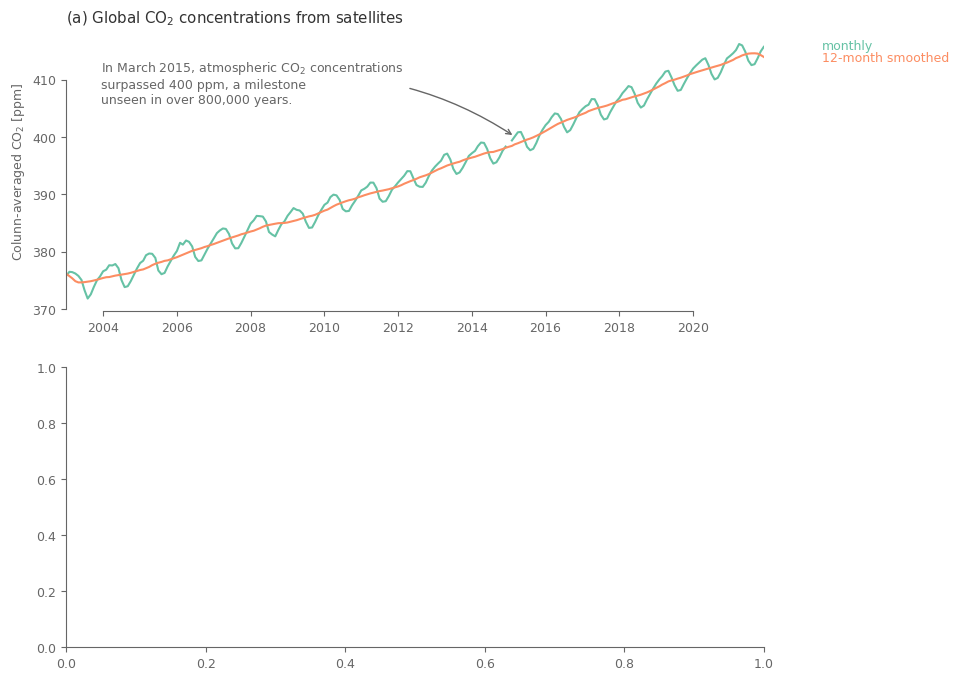

In [18]:
fig, ax = plt.subplots(2, 1, figsize=(9, 8))
subtitle = f'(a) Global {aux_var[co2_spatial_average.name]["shortname"]} concentrations from satellites'
y_label = f'Colunn-averaged {aux_var[co2_spatial_average.name]["shortname"]} [{aux_var[co2_spatial_average.name]["units"]}]'
timeseries_plot(dataset_used=co2_spatial_average, dimension_used='type', ax_used=ax[0])

ax[0].set_title(subtitle)
ax[0].set_ylabel(y_label)

# add text about the 400ppm in case of CO2 with an arrow pointing to the maximum value
desc = 'In ' + first_time_400.strftime('%B %Y') 
desc += ', atmospheric CO$_2$ concentrations \nsurpassed 400 ppm, a milestone \nunseen in over 800,000 years.'
ax[0].annotate(
               desc,
               xy=(first_time_400, co2_spatial_average.sel(type='monthly', time=first_time_400).values),
               xytext=(0.05, 0.9),
               textcoords=ax[0].transAxes,
               ha='left', va='top',
               arrowprops=dict(arrowstyle='->', color='.4', connectionstyle='arc3,rad=-0.2')
               )

plt.show()

Plot the CH4 data.

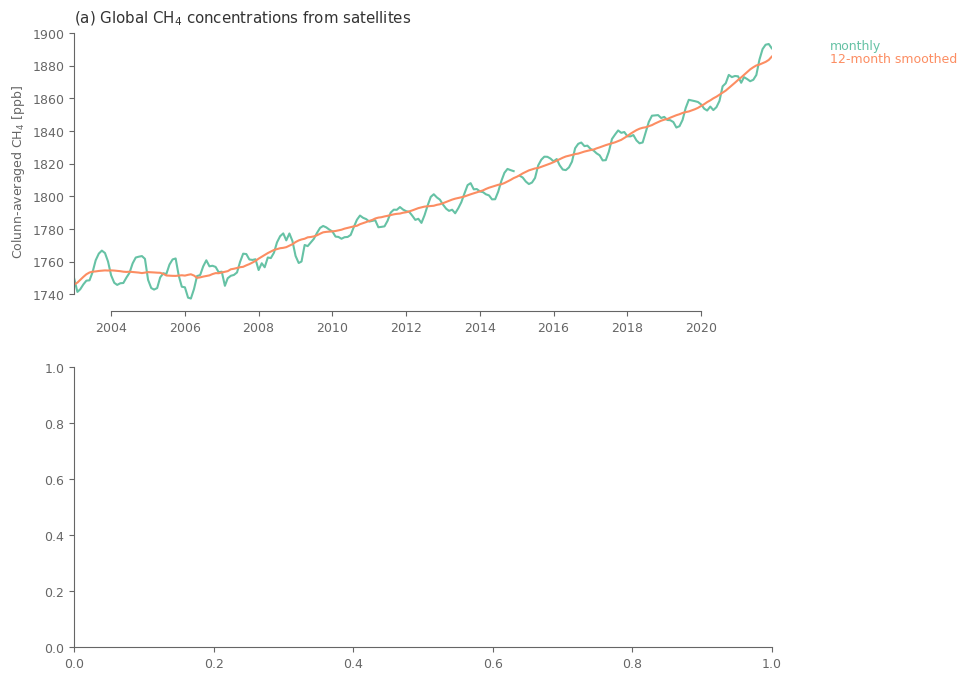

In [19]:
fig, ax = plt.subplots(2, 1, figsize=(9, 8))
subtitle = f'(a) Global {aux_var[ch4_spatial_average.name]["shortname"]} concentrations from satellites'
y_label = f'Colunn-averaged {aux_var[ch4_spatial_average.name]["shortname"]} [{aux_var[ch4_spatial_average.name]["units"]}]'
timeseries_plot(dataset_used=ch4_spatial_average, dimension_used='type', ax_used=ax[0])

ax[0].set_title(subtitle)
ax[0].set_ylabel(y_label)
plt.show()

The above plots show a clear increasing trend in the concentrations of the GHG for all years in the record. Moreover, it can be noticed that there is an evident seasonality for both GHG.

##### To remove this section and add to the above plot

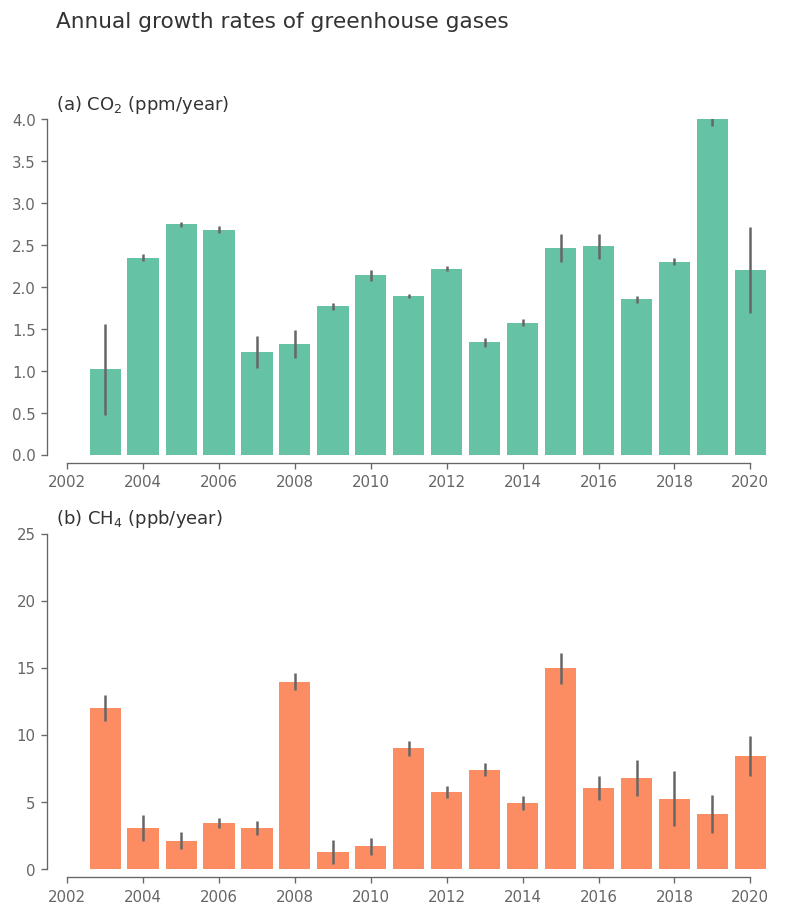

In [13]:
subtitles = ['CO$_2$ (ppm/year)', 'CH$_4$ (ppb/year)']

fig = plt.figure(figsize=(8, 9), dpi=120)
gs = GridSpec(3, 1, figure=fig, height_ratios=[.01, 1, 1], hspace=0.35)

tax = fig.add_subplot(gs[0, 0])
axes = [fig.add_subplot(gs[i, 0]) for i in range(1, 3)]

years = pd.to_datetime(annual_growth_rate_mean.year.values, format='%Y')

axes[0].set_ylim(0, 4)
axes[1].set_ylim(0, 25)
for ax, abc, molecule, title in zip(axes, ABC, ['tcco2', 'tcch4'], subtitles):
    ax.bar(years, annual_growth_rate_mean[molecule], width=datetime.timedelta(days=300), color=aux_var[molecule]['color'])
    ax.errorbar(years, annual_growth_rate_mean[molecule], yerr=annual_growth_rate_stdev[molecule], ls='', color='.4')
    ax.set_title(f'({abc}) ' + title)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    sns.despine(ax=ax, trim=True, offset=5)
tax.axis('off')
tax.set_title('Annual growth rates of greenhouse gases', fontsize='x-large')

The rate of increase is quite varying across the years. Note that for the first and last year the results are not that reliable because the smoothed data that were used don't have all necessary values (the values are based on centered data, thus by default the few first and last values are not using all data needed for the correct smoothing).

##### Continuing the tutorial

So far we have seen that there is indeed an increasing trend for both variables, while both of them have differences in the seasonal cycle and the annual growth rate.

Let's now compare the behaviour across both variables. Since the values are of substantially different magnitude, we first need to normalize the data for being able to plot them on same plot.

<div class="alert alert-block alert-warning">
<b>NOTE</b><br>Here we will use a simple normalization based on global mean and standard deviation. For the ones interested further, there is a small appendix demonstrating why considering anomalies based on monthly climatology, a method commonly used for other environmental variables, is not the best option in our case.</a></div>

In [20]:
co2_spatial_average_normalized = (co2_spatial_average-co2_spatial_average.mean('time'))/co2_spatial_average.std('time')
ch4_spatial_average_normalized = (ch4_spatial_average-ch4_spatial_average.mean('time'))/ch4_spatial_average.std('time')

normalized = xr.merge([co2_spatial_average_normalized, ch4_spatial_average_normalized]) # combine the dataarrays into one dataset
normalized = normalized.sel(type='monthly', drop=True).to_array('ghg') # keep monthly data & convert to array for using in the plot function

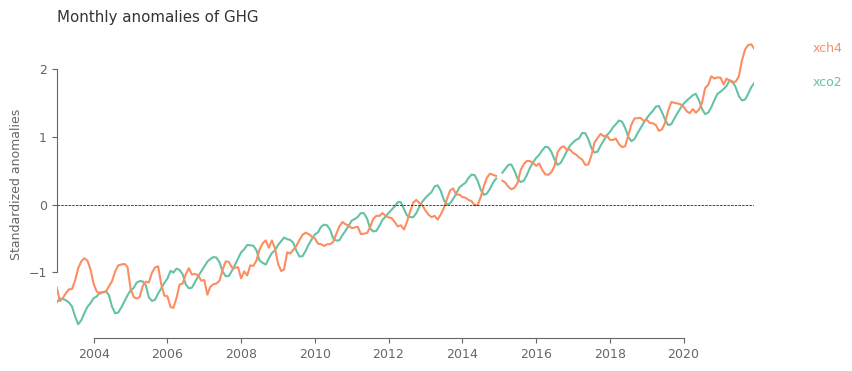

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(9, 4))
timeseries_plot(normalized, 'ghg', ax)
ax.axhline(0, color='k', ls='--', lw=0.5)
ax.set_ylabel('Standardized anomalies')
ax.set_title('Monthly anomalies of GHG')
plt.show()

After the simple normalization it seems that the main differences between the two variables lie in the seasonal cycle, which is shifted.

The above analysis covers a large part of the globe, which does not give us the opportunity to access spatial differences. For this part of the GHG analysis, let's do a spatial refinement and understand how the concentrations evolve in the northern vs southern hemisphere.

In [24]:
studied_domains = {
                  'Global': {'lat': slice(-90, 90)},
                  'Northern Hemishpere': {'lat': slice(0, 90)},
                  'Southern Hemisphere': {'lat': slice(-90, 0)}
                  }

In [25]:
satellites_all = xr.merge([co2_land_data*10**6, ch4_land_data*10**9]) # combine both data in one dataset
satellites_all = satellites_all.to_array('ghg') # convert to dataarray

Calculate the average values for the selected domains.

In [24]:
mean_domains = []
for i, domain in studied_domains.items(): # iterate through the domains
    i_data_subset = spatial_average_function(satellites_all, domain['lat'], 1).isel(type=0, drop=True)
    mean_domains.append( i_data_subset.assign_coords({'domain': i}) )

mean_domains = xr.concat(mean_domains, dim='domain')

# # all the above can be also written in 2 lines based on list-comprehension as below
mean_domains = [spatial_average_function(satellites_all, domain['lat'], 1).isel(type=0, drop=True) for domain in studied_domains.values()]
mean_domains = xr.concat(mean_domains, dim=pd.Index(studied_domains.keys(), name='domain'))

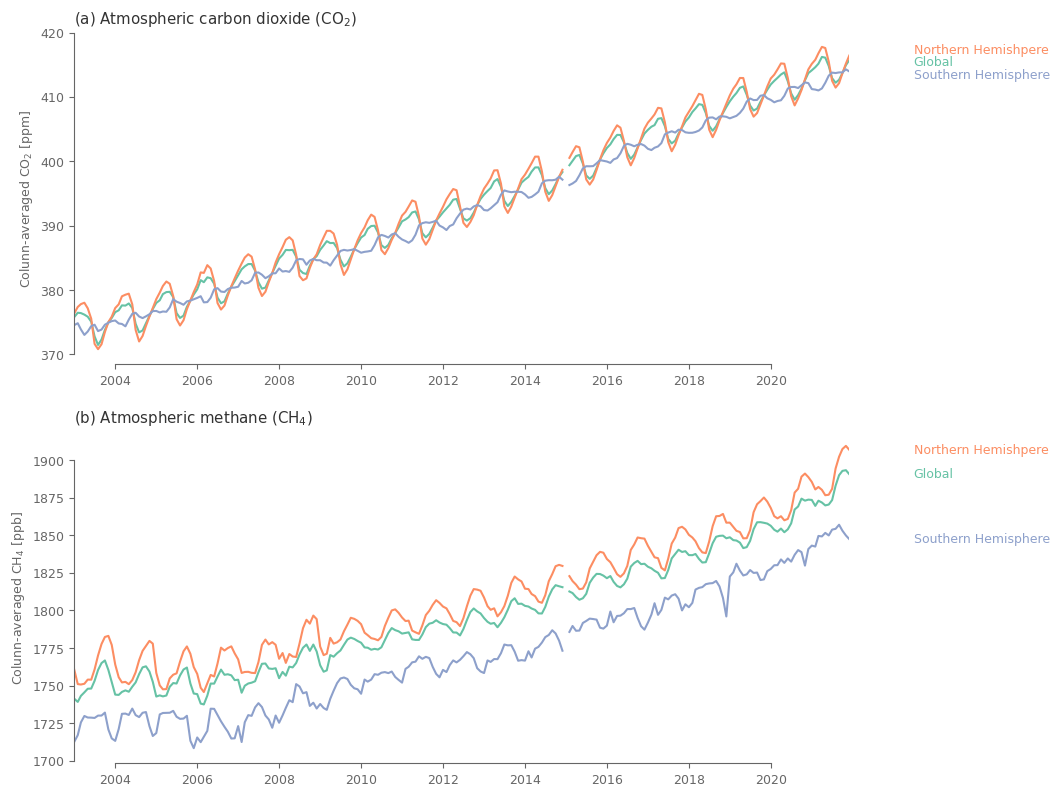

In [25]:
fig, ax = plt.subplots(2, 1, figsize=(10, 9.5))
ax = ax.flatten()
for i_abc, i_ax, i_dom in zip(ABC, ax, mean_domains.ghg):
    subtitle = f'({i_abc}) {aux_var[i_dom.values.tolist()]["name"]} ({aux_var[i_dom.values.tolist()]["shortname"]})'
    y_label = f'Colunn-averaged {aux_var[i_dom.values.tolist()]["shortname"]} [{aux_var[i_dom.values.tolist()]["units"]}]'
    timeseries_plot(dataset_used=mean_domains.sel(ghg=i_dom), dimension_used='domain', ax_used=i_ax)

    i_ax.set_title(subtitle)
    i_ax.set_ylabel(y_label)
    
plt.show()

The methane (CH4) has a clear differentiation in the concentrations between the two hemispheres. CO2 shows no seasonality for the southern hemisphere. Can it be because we only use land, and land mass in the southern hemisphere is substantially smaller compared to the northern?

For both variables the northern hemisphere has the most impact in defining the global mean. What could be possible reasons for that? The larger land mass of northern hemisphere? Or maybe the fact that most of the global population and industrial activities lie in that hemisphere?

The differences are already visible in the hemispheric averages. What about the actual grid cells? Let's find out...

In [26]:
# get the weights for the temporal smoothing based on number of days per month
days_month = [calendar.monthrange(yr, mn)[1] for yr, mn in zip(satellites_all.time.dt.year.values, satellites_all.time.dt.month.values)]
weights_temporal = satellites_all.time.astype(int)*0+days_month # temporal weights as xarray object (helps for automatic arrangements later)
# weights should be changed to NaN for the cells that hava NaN in the measurement
weights_temporal = weights_temporal.where(~np.isnan(satellites_all)).fillna(0)

# created temporally-smoothed timeseries. Note that center=False this time, so the value refers to the 6-month period ending at the date
temp_smoothed = (satellites_all*weights_temporal).rolling(time=6, min_periods=1, center=False).sum()
temp_smoothed /= weights_temporal.rolling(time=6, min_periods=1, center=False).sum()

Define the function for plotting the spatial data for selected variable and 4 dates, with the first 2 refers to a year in the early periods and the last 2 to a more recent year.

In [30]:
def spatial_plot(selected_dates, selected_variable='xco2'):

    """
    Inputs:
    selected_dates: a list with 4 dates
    selected_variable: "xco2" (default) or "xch4"
    """

    # get min/max values for the colorbars for the early and late subsets
    early_dates = temp_smoothed.sel(time=selected_dates[:2], ghg=selected_variable) # get subset of early dates
    min_early = np.floor(early_dates.quantile(.01).values) # find min based on 1st Percentile
    max_early = np.ceil(early_dates.quantile(.99).values) # find max based on 99th Percentile

    late_dates = temp_smoothed.sel(time=selected_dates[2:], ghg=selected_variable)
    min_late = np.floor(late_dates.quantile(.01).values)
    max_late = np.ceil(late_dates.quantile(.99).values)

    # define the figure
    fig, ax = plt.subplots(2, 2, subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(11, 6))
    ax = ax.flatten()

    for i, i_ax in enumerate(ax): # loop through the 4 axes, plot the data, and add background info (Land, Coastline)
        if i<=1:
            values_early = temp_smoothed.sel(time=selected_dates[i], ghg=selected_variable) # get the subset to be plotted 
            plot_early = values_early.plot(ax=i_ax, add_colorbar=False, vmin=min_early, vmax=max_early, extend='both') # plot
        else:
            values_late = temp_smoothed.sel(time=selected_dates[i], ghg=selected_variable)
            plot_late = values_late.plot(ax=i_ax, add_colorbar=False, vmin=min_late, vmax=max_late, extend='both')

        i_ax.add_feature(cfeature.LAND) # add land
        i_ax.add_feature(cfeature.COASTLINE) # add coastline
        # add title
        start_month = (pd.to_datetime(selected_dates[i])-pd.DateOffset(months=5)).strftime("%B") # get start month
        end_month = pd.to_datetime(selected_dates[i])
        i_ax.set_title(end_month.strftime(f'{start_month} - %B %Y')) # add the final title

    # colorbar of early dates
    fig.subplots_adjust(right=1) # define where the new axes fo
    cbar_ax_early = fig.add_axes([1, 0.53, 0.015, 0.34]) # define where the new axis for the colorbar will be added and specify its dimensions
    fig.colorbar(plot_early, cax=cbar_ax_early, extend='both') # add the colorbar
    cbar_ax_early.set_title(f"{aux_var[selected_variable]['shortname']}\n[{aux_var[selected_variable]['units']}]", size=10) # add title

    # colorbar of late dates
    fig.subplots_adjust(right=1)
    cbar_ax_late = fig.add_axes([1, 0.03, 0.015, 0.34])
    fig.colorbar(plot_late, cax=cbar_ax_late, extend='both')
    cbar_ax_late.set_title(f"{aux_var[selected_variable]['shortname']}\n[{aux_var[selected_variable]['units']}]", size=10)

    fig.tight_layout()
    plt.show()

In [ ]:
spatial_plot(['20030601', '20031201', '20210601', '20211201'], 'xco2')

/tmp/ipykernel_1822/2984250472.py:49: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


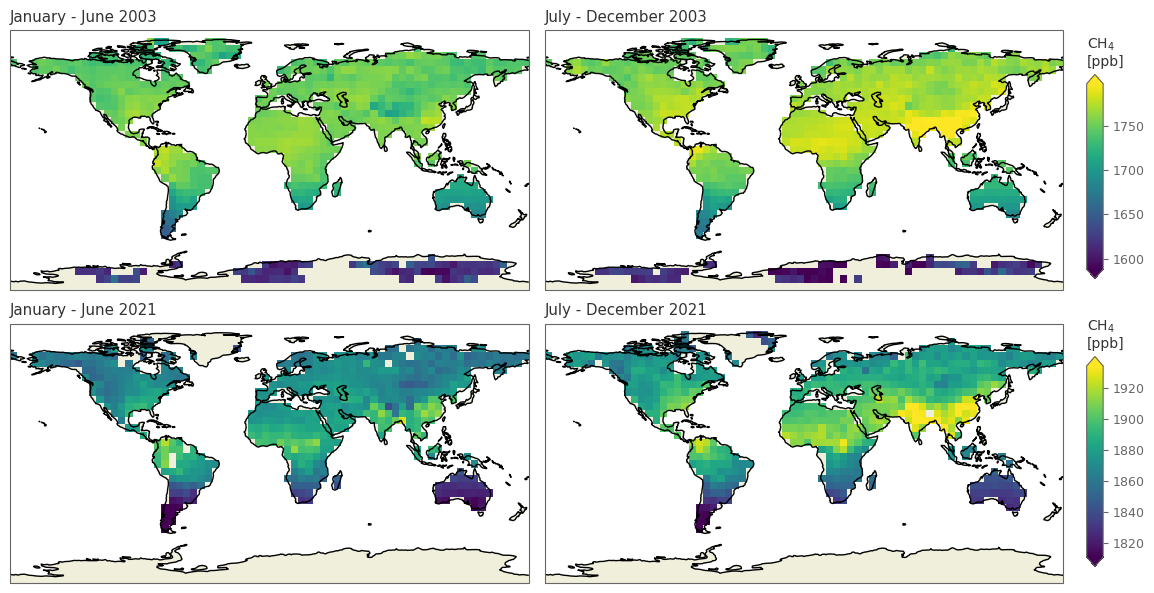

In [32]:
spatial_plot(['20030601', '20031201', '20210601', '20211201'], 'xch4')

<div class="alert alert-block alert-success">
<b>SUMMARY</b><br>In this tutorial we analysed the concentrations of two Greenhouse Gases (GHG), in particular the carbon dioxide (CO2), and the methane (CH4). We used data for the years 2003-2021 based on satellite measurements.<br>
The data showed that both GHG have a systematicly increasing trend of similar slope. This trend is a very alarming feature and as a lot of research has shown, it is the main cause of the ongoing climate change. CO2 and CH4 have a seasonal cycle which is slightly shifted, while there are substantial differences in the concentrations between the two hemispheres, especially so for the CH4.<br>
Now that we have a better understanding about the GHG let's follow our next tutorial <b>INSERT LINK</b>, to find out what is happening in Earth's temperature.</a></div>

### Section 4. Useful links
For the ones interested in finding out more about GHG, please find below some links for relevant articles and visualizations:
1. [Greenhouse gas concentrations Climate Indicators Report](https://climate.copernicus.eu/climate-indicators/greenhouse-gas-concentrations)
2. [Global Monitorin Laboratory](https://gml.noaa.gov/ccgg/) from [NOAA](https://www.noaa.gov/), with a lot of information, relevant plots, and raw data that can be freely donwloaded. 
3. Lashof, D., Ahuja, D. Relative contributions of greenhouse gas emissions to global warming. Nature 344, 529–531 (1990). https://doi.org/10.1038/344529a0
4. Buchwitz, M., Reuter, M., Schneising, O., Noël, S., Gier, B., Bovensmann, H., Burrows, J. P., Boesch, H., Anand, J., Parker, R. J., Somkuti, P., Detmers, R. G., Hasekamp, O. P., Aben, I., Butz, A., Kuze, A., Suto, H., Yoshida, Y., Crisp, D., and O'Dell, C.: Computation and analysis of atmospheric carbon dioxide annual mean growth rates from satellite observations during 2003–2016, Atmos. Chem. Phys., 18, 17355–17370 (2018), https://doi.org/10.5194/acp-18-17355-2018

### Section 5. Appendices
As we stated previously, we only used global mean and standard deviation for comparing both variables, and we did not use monthly climatology. Let's see how the monthly climatology looks like, and why using it is not the best approach.

#### Appendix A: Monthly climatology of the variables

In [38]:
# what is normally done assuming a 'stationary' behaviour of the variable
climatology_mean = satellites_all.groupby('time.month').mean('time') # climatological mean for each month
climatology_std = satellites_all.groupby('time.month').std('time') # climatological standard deviation for each month
anomalies = (satellites_all.groupby('time.month') - climatology_mean) # anomalies after removing mean
anomalies = anomalies.groupby('time.month')/climatology_std # final anomalies after dividing with standard deviation
anomalies = spatial_average_function(anomalies, slice(-60, 60), 12).isel(type=0, drop=True) # get global average

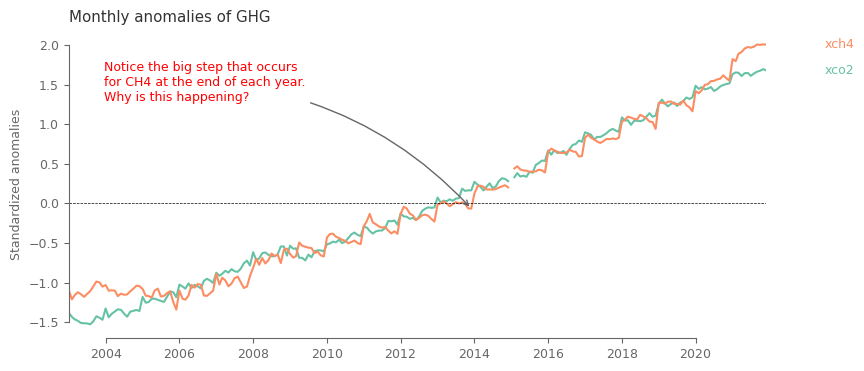

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(9, 4))
timeseries_plot(dataset_used=anomalies, dimension_used='ghg', ax_used=ax)

ax.axhline(0, color='k', ls='--', lw=0.5)
ax.set_xlim(anomalies.time.values[0], anomalies.time.values[-1])
ax.set_title('Monthly anomalies of GHG')
ax.set_ylabel('Standardized anomalies')

date_annotate = pd.to_datetime('201312', format='%Y%m')
ax.annotate(
            'Notice the big step that occurs \nfor CH4 at the end of each year.\nWhy is this happening?',
            xy=(date_annotate, anomalies.sel(ghg='xch4', time=date_annotate).values),
            xytext=(0.05, 0.9),
            textcoords=ax.transAxes,
            ha='left', va='top', color='red',
            arrowprops=dict(arrowstyle='->', color='.4', connectionstyle='arc3,rad=-0.2')
           )

plt.show()

Plot the monthly climatology (global average ) to understand if the issue is related to that step.

In [44]:
clim_spatial = climatology_mean.sel(lat=slice(-60, 60)).weighted(np.cos(np.deg2rad(climatology_mean.lat)).clip(0, 1)).mean(['lat', 'lon'])

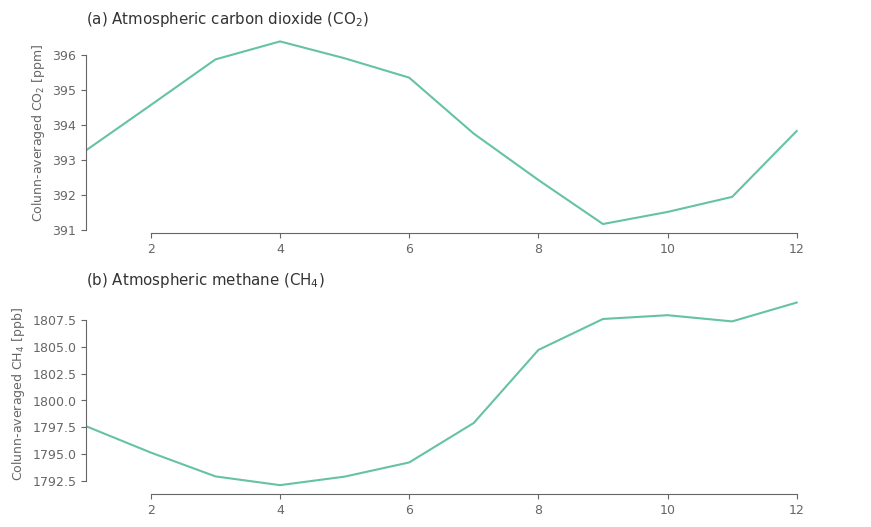

In [45]:
fig, ax = plt.subplots(2, 1, figsize=(10, 6))

for i, j in enumerate(clim_spatial.ghg.values):

    ax[i].plot(clim_spatial.month.values, clim_spatial.sel(ghg=j).values) 
    matplotx.line_labels(ax=ax[i]) # add legend as colored text next to the right end of the relevant line    
    
    ax[i].set_xlim(1, 13)

    ax[i].set_title(f'({ABC[i]}) '+ aux_var[j]['name'] + ' (' + aux_var[j]['shortname'] + ')')
    ax[i].set_ylabel('Colunn-averaged '+ aux_var[j]['shortname']  + ' [' + aux_var[j]['units'] + ']')

    sns.despine(ax=ax[i], trim=True) # trimming the y and x axis to be visible only from the fist till the last tick

plt.subplots_adjust(hspace=.3)

Maybe its more useful to present the results in polar coordinates, since from a climatological point of view the months follow a circular behaviour with December being similar to January.

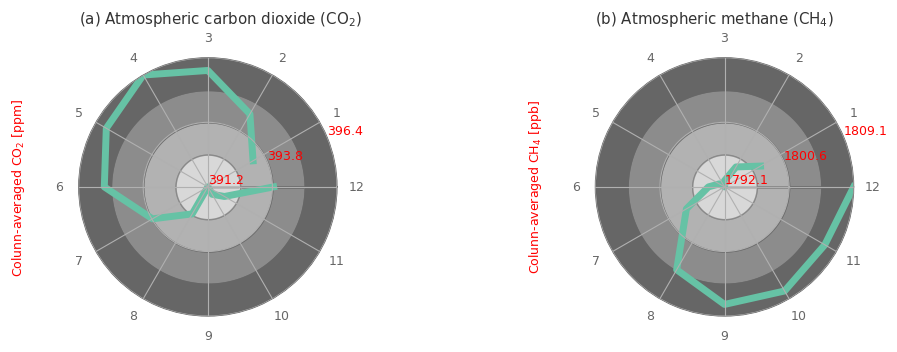

In [62]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10), subplot_kw={'projection': 'polar'})

for i, j in enumerate(clim_spatial.ghg.values):

    yy_values = clim_spatial.sel(ghg=j).values
    ax[i].plot( (clim_spatial.month.values)/12*2*np.pi, yy_values, linewidth=5 )
    
    # color the graph based on y value for easily differentiating between the magnitudes for the months
    segments = np.linspace(np.array(yy_values).min()*1, np.array(yy_values).max()*1., 5)
    for seg_min, seg_max, i_alpha in zip(segments[:-1], segments[1:], np.arange(0.25, 1.01, .25)):
        ax[i].fill_between(x=np.linspace(0, 2*np.pi, 360), y1=seg_max, y2=seg_min, color='.4', alpha=i_alpha)

    ax[i].set_ylim(np.array(yy_values).min()*1, np.array(yy_values).max()*1.)
    
    ax[i].set_xticks((clim_spatial.month.values)/12*2*np.pi)
    ax[i].set_xticklabels(range(1, 13))
    ax[i].set_yticks(segments[::2], labels=np.round(segments, 1)[::2])
    ax[i].set_axisbelow(False) # otherwise the green line hiddes the yticks (red values) 
    ax[i].tick_params(axis='y', colors='red', size=14, zorder=10)
    ax[i].set_title(f'({ABC[i]}) '+ aux_var[j]['name'] + ' (' + aux_var[j]['shortname'] + ')')
    ax[i].yaxis.set_label_coords(-0.2, 1)
    ax[i].set_ylabel('Colunn-averaged '+ aux_var[j]['shortname']  + ' [' + aux_var[j]['units'] + ']', color='red')

plt.subplots_adjust(wspace=1)

Notice the difference in the values between January mean state and December mean state for both GHG, especially so for CH4. This indicates that on average just in the course of 1 single year there is already a substantial increase in the concentrations, that do alter the expected seasonal cycle, as we normally would expect to see the Jan and Dec values being very very close.

Because of this substantial reduction in the mean state of January compared to Decembers we see the high jump for every January, as the climatological mean is small, thus the anomalies get large.

Therefore, in order to get the anomalies in a robust way, we should not only remove the seasonal cycle, but also detrend the data!

#### Appendix B: Using reanalysis data available at the Atmopshere Data Store (ADS)

Besides satellite measurements for the GHG there are also global reanalysis products providing information about CO2 and CH4. Let's use the one available in the Atmosphere Data Store (ADS).</br>
As we did with the CDS API, the same is also needed for the ADS, with a new registration to be completed at https://ads.atmosphere.copernicus.eu/api-how-to.

In [47]:
# ADS key
ads_url = 'https://ads.atmosphere.copernicus.eu/api/v2'
ads_key = 'YOUR KEY' # please add your key here the format should be as {uid}:{api-key}

Get GHG data from reanalysis [(EGG4) from ADS](https://ads.atmosphere.copernicus.eu/cdsapp#!/dataset/cams-global-ghg-reanalysis-egg4-monthly?tab=overview). We use the monthly mean data for speeding the process. For the ones interested there is also a [daily dataset](https://ads.atmosphere.copernicus.eu/cdsapp#!/dataset/cams-global-ghg-reanalysis-egg4?tab=overview) available. 

In [8]:
# get monthly mean grennhouse gases data from Atmosphere Data Store (it takes around 2 minutes)
c = cdsapi.Client(url=ads_url, key=ads_key)

c.retrieve(
    'cams-global-ghg-reanalysis-egg4-monthly',
    {
     'product_type': 'monthly_mean',
     'variable': ['ch4_column_mean_molar_fraction', 'co2_column_mean_molar_fraction'], # get the available variables
     'year': list(range(2003, 2021)), # get all available years (2003, 2004, ..., 2020)
     'month': list(range(1, 13)), # get all months Jan (1) up to Dec (12)
     'format': 'netcdf',
    },
    f'{dir_loc}greenhouse_gases.nc')

2023-06-07 11:22:09,070 INFO Welcome to the CDS
2023-06-07 11:22:09,071 INFO Sending request to https://ads.atmosphere.copernicus.eu/api/v2/resources/cams-global-ghg-reanalysis-egg4-monthly
2023-06-07 11:22:09,276 INFO Request is completed
2023-06-07 11:22:09,278 INFO Downloading https://download-0003-ads-clone.copernicus-climate.eu/cache-compute-0003/cache/data1/adaptor.mars.external-1683983665.986999-18127-5-994cf598-7b63-4f76-915e-6310a89f2575.nc to data/greenhouse_gases.nc (95.3M)
2023-06-07 11:23:48,749 INFO Download rate 981.3K/s 


Result(content_length=99952612,content_type=application/x-netcdf,location=https://download-0003-ads-clone.copernicus-climate.eu/cache-compute-0003/cache/data1/adaptor.mars.external-1683983665.986999-18127-5-994cf598-7b63-4f76-915e-6310a89f2575.nc)

In [48]:
# open the GHG data and inspect the Dataset
# when the data are opened as below using "with" then the link to the actual dataset is closed, meaning that any other program can also access the file in the directory
# this is not the case for the normal opening of the file, as for the co2_satellites in the main section of this tutorial.
with xr.open_dataset(f'{dir_loc}greenhouse_gases.nc') as ghg_reanalysis:
    pass
ghg_reanalysis

<xarray.Dataset>
Dimensions:    (longitude: 480, latitude: 241, time: 216)
Coordinates:
  * longitude  (longitude) float32 0.0 0.75 1.5 2.25 ... 357.0 357.8 358.5 359.2
  * latitude   (latitude) float32 90.0 89.25 88.5 87.75 ... -88.5 -89.25 -90.0
  * time       (time) datetime64[ns] 2003-01-01 2003-02-01 ... 2020-12-01
Data variables:
    tcch4      (time, latitude, longitude) float32 ...
    tcco2      (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-05-13 13:14:27 GMT by grib_to_netcdf-2.25.1: /opt/ecmw...

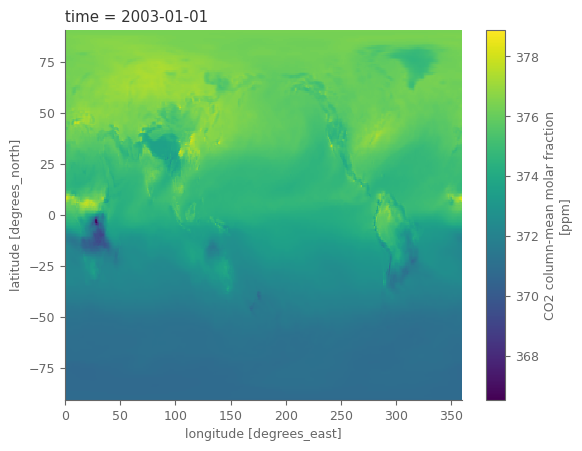

In [49]:
# "quick and dirty" plot of the data
ghg_reanalysis['tcco2'].isel(time=0).plot()

As we can notice, the dataset is a 3-dimensional cube (latitude, longitude, time) with information for two variables (C02, CH4). Also the spatial grid is 0.75 degrees and the data are also over the oceans. We see that this dataset has therefore some differences with the data from the satellites. This will make the task slightly more challenging, but its always nice to be able to see the results with more than 1 datasets... :)

Last data we need is the land-sea mask from ERA5 data. This is needed because the GHG measurements from the satellites are not available over the oceans. So we want to use also a mask for when using GHG data from the reanalysis dataset available from ADS. Note that the resolution (grid) should be specified, because the original one (0.25) is different that the resolution of GHG (0.75).

In [25]:
c = cdsapi.Client(url=cds_url, key=cds_key)

# we just need one random slice of land-sea mask (data are same for all time steps)
c.retrieve(
    'reanalysis-era5-single-levels',
    {
     'product_type': 'reanalysis',
     'variable': 'land_sea_mask',
     'year': '2009',
     'month': '10',
     'day': '16',
     'time': '00:00',
     'grid': [0.75, 0.75], # grid is specified because the default resolution is different
     'format': 'netcdf',
    },
    f'{dir_loc}land_sea_mask.nc')

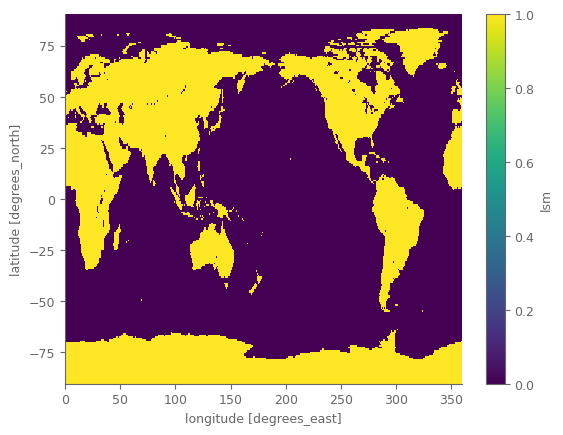

In [50]:
# read the land-sea mask and visualize ("quick and dirty") the data
data_mask = xr.open_dataarray(f'{dir_loc}land_sea_mask.nc').isel(time=0, drop=True)
is_land = data_mask >= 0.5 # make data boolean (1-land, 0-sea), by converting all cells with at least 50% land, as only land
is_land.plot()

For start, let's apply the land mask on the reanalysis data, so that they are comperable with the satellite ones. Also, let's name the coordinates and keys with the same name as with satellite data, and also have the same order (asceding) for the latitudes.

In [51]:
ghg_reanalysis_land = ghg_reanalysis.where(is_land) # keep only land data
ghg_reanalysis_land = ghg_reanalysis_land.sortby('latitude') # sort ascending
ghg_reanalysis_land = ghg_reanalysis_land.rename({'latitude': 'lat', 'longitude': 'lon'}) # rename same as satellite coordinates
ghg_reanalysis_land = ghg_reanalysis_land.rename({'tcch4': 'xch4', 'tcco2': 'xco2'}) # rename same as satellite names
ghg_reanalysis_land = ghg_reanalysis_land.to_array('ghg')

Create the final array with combining the data from both products and deriving the global average.

In [52]:
ghg_both_datasets = xr.concat([satellites_all, ghg_reanalysis_land], dim=pd.Index(['satellites', 'reanalysis'], name='product'))
ghg_both_datasets = spatial_average_function(ghg_both_datasets, slice(-60, 60), 12)

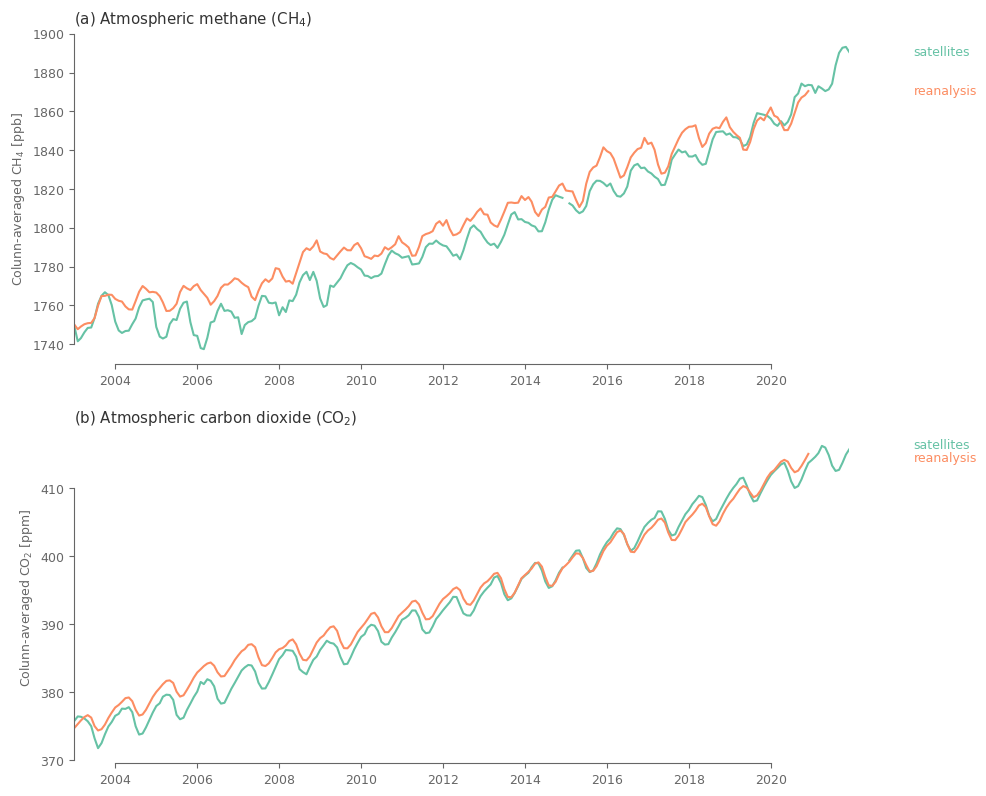

In [53]:
fig, ax = plt.subplots(2, 1, figsize=(10, 9.5))
ax = ax.flatten()
for i_abc, i_ax, i_dom in zip(ABC, ax, ghg_both_datasets.ghg):
    subtitle = f'({i_abc}) {aux_var[i_dom.values.tolist()]["name"]} ({aux_var[i_dom.values.tolist()]["shortname"]})'
    y_label = f'Colunn-averaged {aux_var[i_dom.values.tolist()]["shortname"]} [{aux_var[i_dom.values.tolist()]["units"]}]'
    timeseries_plot(dataset_used=ghg_both_datasets.sel(ghg=i_dom, type='monthly'), dimension_used='product', ax_used=i_ax)

    i_ax.set_title(subtitle)
    i_ax.set_ylabel(y_label)
    
plt.show()

Both satellites and reanalysis data indicate the strong increasing trend for both GHG, with the trend being of similar magnitude.</br>
At the same time we can observe some differences:</br>
For the CO2 data the differences are mainly in the magnitude of the concentrations for around the first half of the data (2003-2013). For the CH4 though, the differences are more substantial, with higher magnitudes and for most of the analysed period. These differences can be related to the methodology for generating the products, and the fact that satellite data are not complete in space and time, so there could be important information omitted.